## Problem Statement

The number of reported results vary daily. Develop a model to explain this variation and use your model to create a prediction interval for the number of reported results on March 1, 2023. Do any attributes of the word affect the percentage of scores reported that were played in Hard Mode? If so, how? If not, why not?

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit

First, read the dates and the corresponding data.

In [66]:
df = pd.read_excel("./dataset/wordle_data.xlsx", index_col=0, usecols="A,C,D,E")
df["h/t"] = df["hard_mode_num"] / df["result_num"]
df = df.sort_index()
df

,word,result_num,hard_mode_num,trial_1,trial_2,trial_3,trial_4,trial_5,trial_6,trial_x,h/t
date,,,,,,,,,,,
2022-01-07,slump,80630,1362,1,3,23,39,24,9,1,0.016892
2022-01-08,crank,101503,1763,1,5,23,31,24,14,2,0.017369
2022-01-09,gorge,91477,1913,1,3,13,27,30,22,4,0.020912
2022-01-10,query,107134,2242,1,4,16,30,30,17,2,0.020927
2022-01-11,drink,153880,3017,1,9,35,34,16,5,1,0.019606
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,condo,20879,2012,0,2,17,35,29,14,3,0.096365
2022-12-28,impel,20160,1937,0,3,21,40,25,9,1,0.096081
2022-12-29,havoc,20001,1919,0,2,16,38,30,12,2,0.095945


Break the words down to characters.

In [67]:
df_chars = pd.DataFrame(index=df.index, data=[ch for ch in df["word"].apply(func=list).values], columns=["ch1", "ch2", "ch3", "ch4", "ch5"])
df[df_chars.columns] = df_chars

We analyze the relation between the percentage of scores reported that are played in the Hard Mode and the occurence of each character in the words,

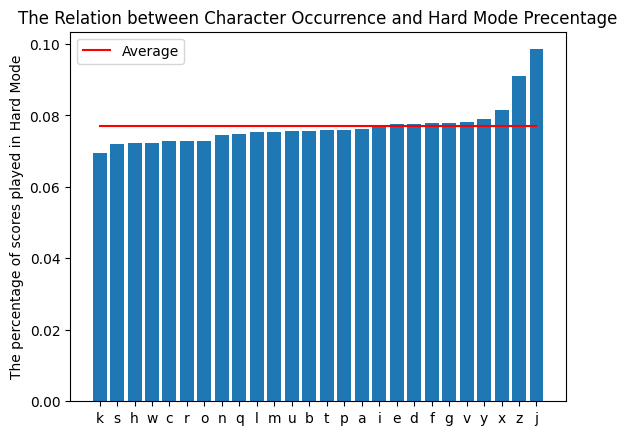

In [77]:
char_av = df.melt(value_vars=["ch1", "ch2", "ch3", "ch4", "ch5"], var_name="ch_pos", value_name="char",id_vars=["h/t"])[["char","h/t"]] \
            .groupby(by="char").mean().reset_index().sort_values(by="h/t")
plt.bar(char_av["char"], char_av["h/t"])
plt.plot(char_av["char"], [char_av["h/t"].mean() for _ in range(len(char_av["char"]))], label="Average", color="red")
plt.ylabel("The percentage of scores played in Hard Mode")
plt.title("The Relation between Character Occurrence and Hard Mode Precentage")
plt.legend()
plt.show()

From above, we can see that the percentage of scores played in Hard Mode for words including the letters "e", "d", "f", "g", "v", "y", "x", "z", and "j" are above average, and that for those including the letters "x", "z", and "j" are significantly higher. Apart from character occurrence, we are also interested in the relationship between the Hard Mode percentage and the frequency of a character among its occurrences in all provided data.

In [69]:
df_melted = df.melt(value_vars=["ch1", "ch2", "ch3", "ch4", "ch5"], var_name="ch_pos", value_name="char",id_vars=["h/t"])
df_freq = (df_melted[["char"]].value_counts() / len(df_melted)).reset_index()
df_freq.columns = ["char", "frequency"]
df_freq = pd.merge(char_av, df_freq, on=["char"]).sort_values(by="frequency")
df_modfreq = df_freq.drop_duplicates(subset=["frequency"])

We will plot the data points and smooth it out with a curve.

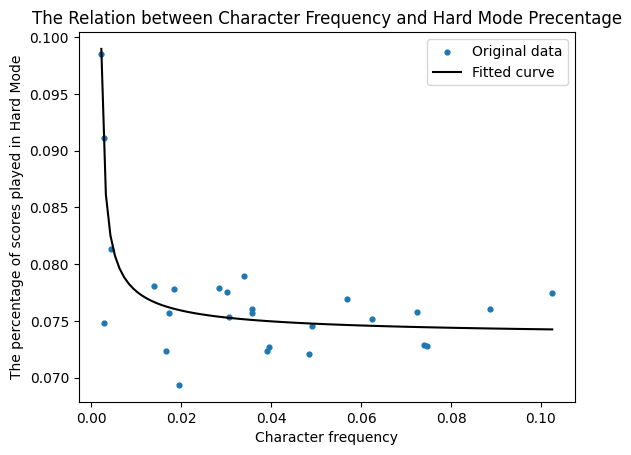

In [79]:
curve = lambda x, a, b, c: a * (x + b) ** (-2/3) + c
params, _ = curve_fit(curve, df_modfreq["frequency"], df_modfreq["h/t"])
xrange = np.linspace(df_freq["frequency"].min(), df_freq["frequency"].max(), 100)
plt.scatter(df_freq["frequency"], df_freq["h/t"], s=12, label="Original data")
plt.plot(xrange, curve(xrange, *params), label="Fitted curve", color="black")
plt.xlabel("Character frequency")
plt.ylabel("The percentage of scores played in Hard Mode")
plt.title("The Relation between Character Frequency and Hard Mode Precentage")
plt.legend()
plt.show()

We can see that cirtically low character frequencies may imply a significantly large percentage of scores played in Hard Mode.